Project Goal: predict the number of future retweets a tweet can expect based on tweets so far, words used, and users' follwers

I used the Twitter API to make a json of 250,000 tweets with the word "recipe" tweeted over an 8-day period.  I then used spark to process that json into a csv file summarizing the tweet's text, it's age, it's number of retweets, hashtags, and followers.  For retweets, I also extracted the age of the original tweet, and the original tweet's user's number of followers.

The tweet's text was converted to lowercase and cleaned of punctuation and stop words.

I setup spark to process the csv

In [1]:
import os
from pyspark import SparkContext

sc = SparkContext("local[*]", "temp")

def localpath(path):
    return 'file://' + str(os.path.abspath(os.path.curdir)) + '/' + path

In [2]:
from pyspark.sql import SQLContext
from pyspark import SparkContext
sqlContext=SQLContext(sc)

csv_lines=sc.textFile(localpath('recipe_retweets_2020_12_17.csv'))

Using spark, I filtered the csv for lines with all the elements, converted into tuples, filtered original tweets from retweets, and calculated the percent of tweets that were retweeted for each tweet age (0-8 days old) 

In [3]:
import re
from pyspark.sql import SQLContext
sqlContext=SQLContext(sc)

def good_line(s,n):
    el=re.split(',',s)
    if len(el)==n:
        return True
    else:
        return False
        
def from_csv_to_tuple(s):
    el=re.split(',',s)
    try:
        this_id,is_retweet,retweet_no,mins_old,days_old=int(el[0]),int(el[1]),int(el[2]),float(el[3]),float(el[4])
    except:
        this_id,is_retweet,retweet_no,mins_old,days_old=-1,-1,-1,-1,-1
    text=el[5]
    try:
        retweet_lag=float(el[6])
        original_string=' '.join([el[8],el[7],el[9]])
    except:
        retweet_lag,original_string=-1,'na'
    retweet_info=(retweet_lag, original_string)
    try:
        hashtag_no=int(el[10])
    except:
        hashtag_no=0
    followers=el[11]
    return this_id, is_retweet, retweet_no, mins_old, days_old, text, retweet_info, hashtag_no, followers
    
def add(x,y):
    return (x[0]+y[0],x[1]+y[1])

def percent_retweeted(x):
    return (x[0]/x[1])

def summarize_retweets(retweet_info):
    retweet_id=retweet_info[0]
    original_tweet_info=retweet_info[6][1]
    retweet_lag=retweet_info[6][0]
    return (original_tweet_info, retweet_lag)

def extend_all(x,c):
    if not type(c)==list:
        c=[c]
    if type(x)==list:
        x.extend(c)
        #x=sorted(set(x))
    else:
        x=[x]
        x.extend(c)
        #x=sorted(set(x))
    return x

def count_retweets(x):
    return x[0], len(x[1][1]), x[1][0], x[1][1]

def add(x,y):
    return x[0]+y[0],x[1]+y[1]

def add_retweets(retweet_summary1, retweet_summary2):
    all_lags=extend_all(retweet_summary1[0],retweet_summary2[0])
    all_ids=extend_all(retweet_summary1[1],retweet_summary2[1])
    return all_lags, all_ids

def find_retweet_chances(retweet_info):
    return (round(retweet_info[4]),(int(retweet_info[2]>0),1))

def find_retweet_no(retweet_info):
    retweet_cats=['0-2','0-2','0-2','3-5','3-5','3-5','6-8','6-8','6-8']
    retweet_age_cat=retweet_cats[round(retweet_info[4])]
    return (retweet_age_cat,retweet_info[2])

#filter and convert csv to tuples
retweet_info=csv_lines.filter(lambda line: good_line(line,12))\
                            .map(lambda line: from_csv_to_tuple(line)) 
#separate out original tweets from retweets
original_tweets=retweet_info.filter(lambda retweet_info: retweet_info[1]==0)
total_original_tweets=original_tweets.count()

#calculate the percent of tweets that are retweeted based on the numbers of days old the tweet is
retweet_chances=original_tweets.map(lambda retweet_info: find_retweet_chances(retweet_info))\
                              .reduceByKey(lambda x,y: add(x,y))\
                              .map(lambda x: (x[0],x[1][0]/x[1][1],x[1]))\
                              .toDF(['days_old','retweeted',])

retweet_no_days_bin=original_tweets.map(lambda retweet_info: find_retweet_no(retweet_info))\
                                    .reduceByKey(lambda x,y: extend_all(x,y))\
                                    .collect()

In [114]:
def bin_retweet_no(retweet_info):
    if retweet_info[2]>200:
        return('>200',1)
    elif retweet_info[2]>60:
        return('61-200',1)
    elif retweet_info[2]>20:
        return('21-60',1)
    elif retweet_info[2]>5:
        return('6-20',1)
    elif retweet_info[2]>0:
        return('1-5',1)
    else:
        return('0',1)
    
all_retweet_no=original_tweets.map(lambda retweet_info: bin_retweet_no(retweet_info))\
                              .reduceByKey(lambda x,y: x+y)\
                              .sortByKey()\
                              .map(lambda x: (x[0], x[1], x[1]/total_original_tweets))\
                              .take(6)

I binned the original tweets by their number of retweets to quickly observe that about 87% of tweets are never retweeted.  11% get 1-5 retweets and only 1% get 6 or more retweets.  The tuples below compare (retweet number bin, observed original tweets in bin, percent of all original tweets).  Only 31 out of 158,601 original tweets were retweeted more than 200 times.

In [115]:
all_retweet_no

[('0', 138866, 0.8755682498849313),
 ('1-5', 17633, 0.11117836583628098),
 ('21-60', 347, 0.002187880278182357),
 ('6-20', 1590, 0.010025157470633855),
 ('61-200', 134, 0.0008448874849465009),
 ('>200', 31, 0.00019545904502493678)]

In [5]:
retweet_no_dict={}
for i in range(len(retweet_no_days_bin)):
    retweet_no_dict[retweet_no_days_bin[i][0]]=retweet_no_days_bin[i][1]

I plotted the cumulative density of retweet number for three different tweet ages.  The age of a tweet does not meaningfully affect its retweet number.

In [6]:
from bokeh.layouts import gridplot
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
from bokeh.models import Range1d, BoxAnnotation

output_notebook()

#what is the distribution of retweet number on tweets for each block of tweet age?
p=figure(title='cumulative density of retweets by tweet age',x_range=Range1d(-1,20),
        y_range=Range1d(.85,1),plot_width=600,plot_height=300)
p.xaxis.axis_label='number of retweets'

linecolor={}
linecolor['0-2']="#f46d43"
linecolor['3-5']="#0000FF"
linecolor['6-8']="#00A86B"

def find_cdf(data):
    x=sorted(data)
    y=[y_i/len(x) for y_i in range(len(data))]
    return x,y

for dict_name in ['0-2','3-5','6-8']:
    x,y=find_cdf(retweet_no_dict[dict_name])
    p.line(x,y,line_color=linecolor[dict_name])
show(p)
    

Loading BokehJS ...

The age of tweet in days also does not affect its chance of being retweeted.

Text(0.5, 1.0, 'tweet age v. chance it has been retweeted')

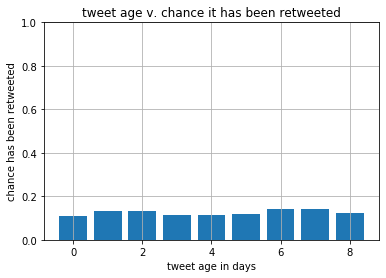

In [8]:
#visualize retweet chances as a function of days since tweet
retweet_chances=original_tweets.map(lambda retweet_info: find_retweet_chances(retweet_info))\
                              .reduceByKey(lambda x,y: add(x,y))\
                              .map(lambda x: (x[0],x[1][0]/x[1][1],x[1]))\
                              .toDF(['days_old','retweeted','total'])

import matplotlib.pyplot as plt
retweet_chances=retweet_chances.toPandas()
plt.grid()
plt.bar(retweet_chances['days_old'],retweet_chances['retweeted'])
plt.xlabel('tweet age in days')
plt.ylabel('chance has been retweeted')
plt.ylim(0,1)
plt.title('tweet age v. chance it has been retweeted')

In [28]:
import numpy as np

p=figure(title='cumulative density of retweets by tweet age',x_range=Range1d(-1,8),
        y_range=Range1d(.85,1),plot_width=600,plot_height=300)
p.xaxis.axis_label='log of number of retweets'

retweet_no_array,log_retweet_no_array={},{}
for key in retweet_no_dict.keys():
    retweet_no_array[key]=np.array(retweet_no_dict[key])
    log_retweet_no_array[key]=np.log(retweet_no_array[key][retweet_no_array[key]>0])
    x,y=find_cdf(log_retweet_no_array[key])
    p.line(x,y,line_color=linecolor[key])
    
show(p)

In [29]:
#find all retweets
retweets=retweet_info.filter(lambda retweet_info: retweet_info[1]==1)
total_retweets=retweets.count()
total_retweets

90892

90892 of the captured tweets are retweets.  While each tweet captured from the original tweet extraction included how many times each original tweet was retweeted (plotted above), the specific timing of each retweet is not described. Instead, the 90892 retweets in the captured data must be organized by original tweet and compared to find the lag at which they were retweeted. I organized them by the original tweet.

In [32]:
import pandas as pd
import numpy as np
#organize by original tweet
def find_retweeted(retweet_info):
    retweet_id=retweet_info[0]
    original_info=retweet_info[6][1]
    retweet_lag=retweet_info[6][0]
    return (original_info, (retweet_id, retweet_lag))
def merge_retweet_info(x,y):
    return (extend_all(x[0],y[0]),extend_all(x[1],y[1]))
def collapse_retweets(x):
    original_tweet_info=re.split(' ',x[0])
    original_age=float(original_tweet_info[1])
    original_followers=int(original_tweet_info[2])
    ids=x[1][0]
    lags=x[1][1]
    if not type(ids)==list:
        ids=[ids]
        lags=[x[1][1]]
    df=pd.DataFrame({'id':ids, 'lag':lags})
    grouped=df.groupby('id').last()
    lag_list=grouped['lag'].tolist()
    retweet_no=len(lag_list)
    return (lag_list, retweet_no, original_age, original_followers)
    
retweeted_tweets=retweets.map(lambda retweet_info: find_retweeted(retweet_info))\
                        .reduceByKey(lambda x,y: merge_retweet_info(x,y))\
                        .map(lambda x: collapse_retweets(x))

In [34]:
def summarize_retweeted(x):
    retweet_no=x[1]
    retweet_age=x[2]
    followers=x[3]
    retweet_lag=x[2]-np.array(x[0])
    first_retweet=retweet_lag[-1].item()
    last_retweet=retweet_lag[0].item()
    silence=x[0][0]
    return (retweet_no,retweet_age/(60*24),followers,retweet_lag,
            first_retweet,last_retweet,silence)

original_ref_tweets=retweeted_tweets.map(lambda x: summarize_retweeted(x))

In [35]:
original_ref_tweets.count()

21063

For each of the 21063 original tweets with retweets in the captured data, I can plot the progression of retweets as a function of time passed after the original tweet. 

In [84]:
original_ref_summary=original_ref_tweets.map(lambda x: (x[0], (x[1], x[2], x[4], x[5], x[6])))\
                                .sortByKey(ascending=False)\
                                .map(lambda x: (x[0], x[1][0], x[1][1], x[1][2], x[1][3], x[1][4]))\
                                .toDF(['retweets','age','followers','first_retweet','last_retweet','silence'])

In [37]:
original_ref_retweets=original_ref_tweets.map(lambda x: (x[0], x[3]))\
                                        .sortByKey(ascending=False)\
                                        .collect()

In [99]:
colors = [
    "#%02x%02x%02x" % (int(r), int(g), int(b)) for r, g, b in 200*np.random.random(size=(10000,3))+[50, 30, 30]
]

A sampling of 1052 original tweet's retweet profiles are shown below

In [102]:
#what is the distribution of retweet number on tweets for each block of tweet age?
p=figure(title='cumulative density of retweets by tweet age',plot_width=600,plot_height=300,
        y_range=Range1d(0,120))
p.xaxis.axis_label='time after original tweet (hours)'
p.yaxis.axis_label='total number of retweets [at extraction]'

j=0
for i in range(30,21060,20):
    retweet_profile=original_ref_retweets[i][1][::-1]
    p.scatter(retweet_profile/60,range(len(retweet_profile)),radius=.5, 
              fill_color=colors[j], line_color=None)
    j+=1
    
show(p)

The reference tweets with retweets in the extracted data (blue-green) are mostly from the 8 days of extraction, but some are much older... even more than a year.  Compare to the original retweet age distribution from the same 8 days (purple).

In [120]:
original_ref_df=original_ref_summary.toPandas()
p=figure(title='cumulative density of original tweet age',x_range=Range1d(0,15),
        y_range=Range1d(0,1),plot_width=600,plot_height=300)
p.xaxis.axis_label='tweet age (days old)'
p.yaxis.axis_label='cumulative probability'

def find_cdf(data):
    x=sorted(data)
    y=[y_i/len(x) for y_i in range(len(data))]
    return x,y

x,y=find_cdf(original_ref_df['age'])
p.line(x,y,line_color=colors[10])
x,y=find_cdf(retweet_chances['days_old'])
p.line(x,y,line_color=colors[1])

show(p)